In [27]:
import torch
from torchtext.legacy import data

In [28]:
TEXT = data.Field(tokenize = 'spacy', lower = True)
LABEL = data.LabelField()

In [29]:
news = data.TabularDataset(
    path='input/News_Category_Dataset_v2.json', format='json',
    fields={'headline': ('headline', TEXT),
            'short_description' : ('desc', TEXT),
             'category': ('category', LABEL)})

In [30]:
import random
SEED = 1234
from tqdm import tqdm_notebook, tqdm

trn, vld, tst = news.split(split_ratio=[0.7, 0.2, 0.1], random_state = random.seed(SEED))

In [31]:
vars(trn[0])

{'headline': ["'", 'train', 'hard', ',', 'land', 'soft', "'"],
 'desc': ['runners',
  'will',
  'appreciate',
  'that',
  'the',
  'sproing',
  'trainer',
  'was',
  'designed',
  'with',
  'them',
  'in',
  'mind',
  'as',
  'a',
  'way',
  'to',
  'build',
  'endurance',
  'and',
  'strength',
  'without',
  'the',
  'pain',
  'that',
  'can',
  'come',
  'with',
  'pounding',
  'the',
  'pavement',
  '.'],
 'category': 'HEALTHY LIVING'}

In [32]:
TEXT.build_vocab(trn, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(trn)

In [33]:
print(len(TEXT.vocab))
print(len(LABEL.vocab))

78590
41


In [34]:
print(LABEL.vocab.stoi)

defaultdict(None, {'POLITICS': 0, 'WELLNESS': 1, 'ENTERTAINMENT': 2, 'TRAVEL': 3, 'STYLE & BEAUTY': 4, 'PARENTING': 5, 'HEALTHY LIVING': 6, 'QUEER VOICES': 7, 'FOOD & DRINK': 8, 'BUSINESS': 9, 'COMEDY': 10, 'SPORTS': 11, 'BLACK VOICES': 12, 'HOME & LIVING': 13, 'PARENTS': 14, 'THE WORLDPOST': 15, 'WEDDINGS': 16, 'DIVORCE': 17, 'WOMEN': 18, 'IMPACT': 19, 'CRIME': 20, 'MEDIA': 21, 'WEIRD NEWS': 22, 'GREEN': 23, 'WORLDPOST': 24, 'RELIGION': 25, 'STYLE': 26, 'SCIENCE': 27, 'TASTE': 28, 'WORLD NEWS': 29, 'TECH': 30, 'MONEY': 31, 'ARTS': 32, 'FIFTY': 33, 'GOOD NEWS': 34, 'ARTS & CULTURE': 35, 'ENVIRONMENT': 36, 'COLLEGE': 37, 'LATINO VOICES': 38, 'CULTURE & ARTS': 39, 'EDUCATION': 40})


In [35]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (trn, vld, tst), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key= lambda x: len(x.headline), 
    sort_within_batch= False
    )

cuda


In [36]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim).to(device)
        
        self.lstm_head = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout).to(device)
        
        self.lstm_desc = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout).to(device)
        
        self.fc_head = nn.Linear(hidden_dim * 2, 100).to(device)
        
        self.fc_desc = nn.Linear(hidden_dim * 2, 100).to(device)

        self.fc_total = nn.Linear(200, output_dim).to(device)
        
        self.dropout = nn.Dropout(dropout).to(device)
                
    def forward(self, headline, description):
                        
        embedded_head = self.dropout(self.embedding(headline))
        
        embedded_desc = self.dropout(self.embedding(description))
                                    
        output_head, (hidden_head, cell_head) = self.lstm_head(embedded_head)
        
        output_desc, (hidden_desc, cell_desc) = self.lstm_desc(embedded_desc)
        
        hidden_head = self.dropout(torch.cat((hidden_head[-2, :, :], hidden_head[-1, :, :]), dim = 1))
        
        hidden_desc = self.dropout(torch.cat((hidden_desc[-2, :, :], hidden_desc[-1, :, :]), dim = 1))
        
        full_head = self.fc_head(hidden_head)
        
        full_desc = self.fc_desc(hidden_desc)
        
        hidden_total = torch.cat((full_head, full_desc), 1)
        
        return self.fc_total(hidden_total)

In [37]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(LABEL.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,590,129 trainable parameters


In [39]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([78590, 100])


In [40]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.9989, -0.8980,  0.5883,  ...,  0.0497,  1.1242, -0.5673],
        [ 0.4828, -0.6313, -2.3372,  ..., -0.8727,  1.7017,  0.3450],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 2.0217,  0.1979,  0.6821,  ..., -0.9427,  0.3168,  1.8482],
        [ 1.5683, -0.0107,  0.2985,  ...,  1.3227,  0.3058, -1.0147],
        [-0.1345,  1.3065, -0.1868,  ...,  0.9936, -0.9653,  1.6021]],
       device='cuda:0')

In [41]:
def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim = 1, keepdim = True).to(device)
    correct = max_preds.squeeze(1).eq(y).to(device)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)

In [42]:
from torchmetrics.functional import accuracy, f1, precision
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()

    # Get the progress bar for later modification
    # progress_bar = tqdm_notebook(iterator, ascii=True)
    for idx, batch in enumerate(iterator):
        
        optimizer.zero_grad()
                        
        predictions = model(batch.headline, batch.desc)
#         print(predictions.shape)
        predictions = predictions.squeeze(1)
#         print(batch.category)
        
        loss = criterion(predictions, batch.category)
        
        acc = categorical_accuracy(predictions, batch.category)
        my_acc = accuracy(predictions, batch.category)
        my_f1 = f1(predictions, batch.category, num_classes=41)
        my_prec = precision(predictions, batch.category, average='micro')
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # progress_bar.set_description_str(
        #     "Batch: %d, Loss: %.4f" % (int(idx + 1), loss.item()))
        
    return epoch_loss / len(iterator), my_acc, my_f1, my_prec

In [43]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            
            predictions = model(batch.headline, batch.desc).squeeze(1)
            
            loss = criterion(predictions, batch.category)
            
            acc = categorical_accuracy(predictions, batch.category)
            my_acc = accuracy(predictions, batch.category)
            my_f1 = f1(predictions, batch.category, num_classes=41)
            my_prec = precision(predictions, batch.category, average='micro')
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), my_acc, my_f1, my_prec


In [44]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [45]:
import numpy as np

cls_num_list = []
cat_map = dict()
for r in news:
    cat = r.category
    if cat not in cat_map:
        cat_map[cat] = 0
    else:
        cat_map[cat] += 1
for v in cat_map.values():
    cls_num_list.append(v)
cls_num_list = sorted(cls_num_list, reverse=True)

In [46]:
from losses.LDAMLoss import LDAMLoss
import torch.optim as optim
lr = 0.0002
betas = [0.9, 0.99999]
weight_decay = 0.00001
# lr = 0.001
# momentum = 0.9
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)  #, betas=betas)
# optimizer = torch.optim.SGD(model.parameters(), lr,
#                             momentum=momentum,
#                             weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       patience=1, threshold=.5,
                                                       cooldown=0, factor=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, last_epoch=-1)
# lr_idx = [0.0005, 0.0005, 0.0001, 0.0001]

In [47]:
N_EPOCHS = 10

best_valid_loss = float('inf')
trainLoss= []
trainAcc = []
valLoss= []
valAcc = []
trainF1 = []
valF1 = []
trainPrec = []
valPrec = []

for epoch in range(N_EPOCHS):

    if epoch+1 <= 5:
        idx = 0
        maxm = 0.25
        s = 10
    else:
        idx = 1
        maxm = 0.5
        s = 30

    betas = [0, 0.9999]
    effective_num = 1.0 - np.power(betas[idx], cls_num_list)
    per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
    per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
    per_cls_weights = torch.FloatTensor(per_cls_weights).to(device)
    # per_cls_weights = per_cls_weights.detach().numpy()
    criterion = LDAMLoss(cls_num_list=cls_num_list, weight=per_cls_weights, max_m=maxm, s=s)
    model = model.to(device)
    criterion = criterion.to(device)


    start_time = time.time()

    train_loss, train_acc, train_f1, train_prec = train(model, train_iterator, optimizer, criterion)
    trainLoss.append(train_loss)
    trainAcc.append(train_acc)
    trainF1.append(train_f1)
    trainPrec.append(train_prec)
    scheduler.step(train_loss)
    valid_loss, valid_acc, valid_f1, valid_prec = evaluate(model, valid_iterator, criterion)
    valLoss.append(valid_loss)
    valAcc.append(valid_acc)
    valF1.append(valid_f1)
    valPrec.append(valid_prec)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Train F1: {train_f1*100:.2f} | Train Precision: {train_prec*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f}  |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'\t Valid F1: {valid_f1*100:.2f} | Val Precision: {valid_prec*100:.2f}%')
    llrr = optimizer.param_groups[0]['lr']
    print(f'\t LR: {llrr:.10f}')
    # optimizer.param_groups[0]['lr'] = lr_idx[epoch]

Epoch: 01 | Epoch Time: 1m 19s
	 Train Loss: 3.056 | Train Acc: 56.25%
	 Train F1: 56.25 | Train Precision: 56.25%
	 Val. Loss: 2.569  |  Val. Acc: 56.60%
	 Valid F1: 56.60 | Val Precision: 56.60%
	 LR: 0.0002000000
Epoch: 02 | Epoch Time: 1m 13s
	 Train Loss: 2.439 | Train Acc: 59.38%
	 Train F1: 59.38 | Train Precision: 59.38%
	 Val. Loss: 2.349  |  Val. Acc: 67.92%
	 Valid F1: 67.92 | Val Precision: 67.92%
	 LR: 0.0002000000
Epoch: 03 | Epoch Time: 1m 15s
	 Train Loss: 2.201 | Train Acc: 64.06%
	 Train F1: 64.06 | Train Precision: 64.06%
	 Val. Loss: 2.206  |  Val. Acc: 66.04%
	 Valid F1: 66.04 | Val Precision: 66.04%
	 LR: 0.0000200000
Epoch: 04 | Epoch Time: 1m 18s
	 Train Loss: 1.976 | Train Acc: 59.38%
	 Train F1: 59.38 | Train Precision: 59.38%
	 Val. Loss: 2.123  |  Val. Acc: 69.81%
	 Valid F1: 69.81 | Val Precision: 69.81%
	 LR: 0.0000200000
Epoch: 05 | Epoch Time: 1m 19s
	 Train Loss: 1.936 | Train Acc: 71.88%
	 Train F1: 71.88 | Train Precision: 71.88%
	 Val. Loss: 2.114  |

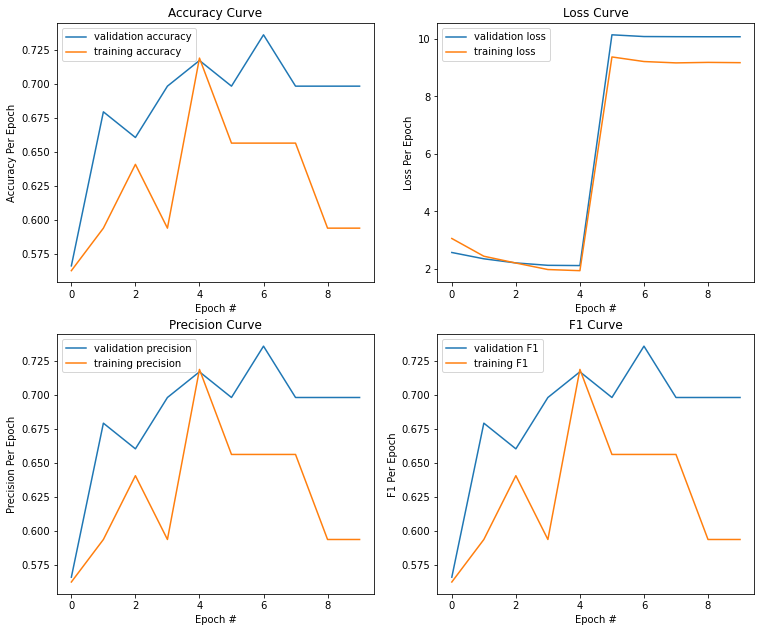

In [48]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure, axis = plt.subplots(2, 2)
figure.set_size_inches(12.5, 10.5, forward=True)
axis[0, 0].plot(valAcc, label='validation accuracy')
axis[0, 0].plot(trainAcc, label='training accuracy')
axis[0, 0].set_xlabel('Epoch #')
axis[0, 0].set_ylabel('Accuracy Per Epoch')
axis[0, 0].set_title('Accuracy Curve')
axis[0, 0].legend()
axis[0, 1].plot(valLoss, label='validation loss')
axis[0, 1].plot(trainLoss, label='training loss')
axis[0, 1].set_xlabel('Epoch #')
axis[0, 1].set_ylabel('Loss Per Epoch')
axis[0, 1].set_title('Loss Curve')
axis[0, 1].legend()
axis[1, 0].plot(valPrec, label='validation precision')
axis[1, 0].plot(trainPrec, label='training precision')
axis[1, 0].set_xlabel('Epoch #')
axis[1, 0].set_ylabel('Precision Per Epoch')
axis[1, 0].set_title('Precision Curve')
axis[1, 0].legend()
axis[1, 1].plot(valF1, label='validation F1')
axis[1, 1].plot(trainF1, label='training F1')
axis[1, 1].set_xlabel('Epoch #')
axis[1, 1].set_ylabel('F1 Per Epoch')
axis[1, 1].set_title('F1 Curve')
axis[1, 1].legend()

In [49]:
test_loss, test_acc, my_test_f1, my_test_prec = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} '
      f'| Test Acc: {test_acc*100:.2f}'
      f'| Test F1: {my_test_f1*100:.2f} | Test Prec: {my_test_prec*100:.2f}%')

Test Loss: 10.164 | Test Acc: 62.79| Test F1: 62.79 | Test Prec: 62.79%


In [50]:
import spacy
nlp = spacy.load('en')

def predict_category(model, head, desc):
    model.eval()
    head = head.lower()
    desc = desc.lower()
    tokenized_head = [tok.text for tok in nlp.tokenizer(head)]
    tokenized_desc = [tok.text for tok in nlp.tokenizer(desc)]
    indexed_head = [TEXT.vocab.stoi[t] for t in tokenized_head]
    indexed_desc = [TEXT.vocab.stoi[t] for t in tokenized_desc]
    tensor_head = torch.LongTensor(indexed_head).to(device)
    tensor_desc = torch.LongTensor(indexed_desc).to(device)
    tensor_head = tensor_head.unsqueeze(1)
    tensor_desc = tensor_desc.unsqueeze(1)
    prediction = model(tensor_head, tensor_desc)
    max_pred = prediction.argmax(dim=1)
    return max_pred.item()

News headline: Trump’s Art Of Distraction

News short description: The conversation surrounding Trump’s latest racist rants has provoked us to revisit author Toni Morrison’s 1975 keynote address at Portland State University on the true purpose of racism.

Correct category: Politics

In [51]:
pred = predict_category(model, "Trump’s Art Of Distraction", "The conversation surrounding Trump’s latest racist rants has provoked us to revisit author Toni Morrison’s 1975 keynote address at Portland State University on the true purpose of racism..")
print(f'Predicted category is: {pred} = {LABEL.vocab.itos[pred]}')

Predicted category is: 0 = POLITICS


News headline: Indiana Cop Apologizes After Accusing McDonald’s Worker Of Eating His Sandwich

News short description: The Marion County sheriff’s deputy forgot he had taken a bite out of his McChicken earlier that day, authorities said.

Correct category: U.S. News

In [52]:
pred = predict_category(model, "Indiana Cop Apologizes After Accusing McDonald’s Worker Of Eating His Sandwich", "The Marion County sheriff’s deputy forgot he had taken a bite out of his McChicken earlier that day, authorities said.")
print(f'Predicted category is: {pred} = {LABEL.vocab.itos[pred]}')

Predicted category is: 20 = CRIME


News headline: Kyle ‘Bugha’ Giersdorf, 16, Wins Fortnite World Cup And Takes Home $ 3 Million Prize

News short description: Fortnite has nearly 250 million registered players and raked in an estimated $2.4 billion last year.

Correct category: Sports

In [53]:
pred = predict_category(model, "Kyle ‘Bugha’ Giersdorf, 16, Wins Fortnite World Cup And Takes Home $ 3 Million Prize", "Fortnite has nearly 250 million registered players and raked in an estimated $2.4 billion last year.")
print(f'Predicted category is: {pred} = {LABEL.vocab.itos[pred]}')

Predicted category is: 19 = IMPACT


**References**

This notebook was created thanks to the two references below.
* http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
* https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb